In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [245]:
input_label = 'aggregated'

input_file = f'fit-{input_label}-20k.csv'

equalized = False

In [246]:
data = pd.read_csv(input_file)

In [247]:
data['tprs'] = data['tprs'].apply(lambda x: np.array(eval(x)))
data['fprs'] = data['fprs'].apply(lambda x: np.array(eval(x)))
data['fracs'] = data['fracs'].apply(lambda x: np.array(eval(x)))

In [248]:
data[['exp_tpr', 'exp_fpr']].median()

exp_tpr    1.710321
exp_fpr    0.623637
dtype: float64

Text(0, 0.5, 'frequency')

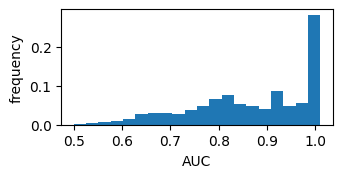

In [249]:
plt.figure(figsize=(3.5, 1.5))
plt.hist(data['auc'], bins=np.linspace(0.5, 1.01, 21), weights=np.repeat(1/len(data), len(data)))
plt.xlabel('AUC')
plt.ylabel('frequency')

In [250]:
if equalized:
    n_samples = 300

    tmp = []
    lower_bounds = np.linspace(0.5, 1.0, 11)
    for lower, upper in zip(lower_bounds[:-1], lower_bounds[1:]):
        if upper == 1.0:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] <= upper)]
        else:
            tmp2 = data[(data['auc'] >= lower) & (data['auc'] < upper)]
        if len(tmp2) > n_samples:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=False))
        else:
            tmp.append(tmp2.sample(n_samples, random_state=5, replace=True))
    data = pd.concat(tmp)

Text(0, 0.5, 'frequency')

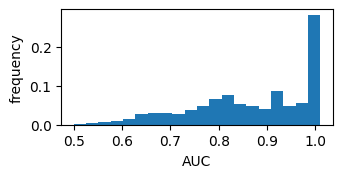

In [251]:
plt.figure(figsize=(3.5, 1.5))
plt.hist(data['auc'], bins=np.linspace(0.5, 1.01, 21), weights=np.repeat(1/len(data), len(data)))
plt.xlabel('AUC')
plt.ylabel('frequency')

In [252]:
len(data)

20000

In [253]:
data[['exp_tpr', 'exp_fpr', 'n_nodes', 'r2_fpr', 'r2_tpr']]

,exp_tpr,exp_fpr,n_nodes,r2_fpr,r2_tpr
0,1.145565,0.845231,10,0.999928,0.999803
1,1.352209,0.612250,35,0.911583,0.986076
2,2.203507,0.712773,19,0.992456,0.886215
3,1.422496,0.468695,53,0.804466,0.960326
4,1.261925,0.918307,56,0.998965,0.985555
...,...,...,...,...,...
19995,3.289822,0.504546,13,0.979670,0.994796
19996,1.114335,0.841347,17,0.997230,0.999333
19997,1.039934,0.909885,8,0.999810,0.999969
19998,1.183108,0.935385,13,0.999668,0.998215


In [254]:
data[['r2_fpr', 'r2_tpr']].mean()#, data[['r2_fpr_train', 'r2_tpr_train']].mean()

r2_fpr    0.966835
r2_tpr    0.968467
dtype: float64

In [255]:
data[['r2_fpr', 'r2_tpr']].median()#, data[['r2_fpr_train', 'r2_tpr_train']].median()

r2_fpr    0.991997
r2_tpr    0.992420
dtype: float64

In [256]:
data[['r2_fpr', 'r2_tpr']].min()#, data[['r2_fpr_train', 'r2_tpr_train']].min()

r2_fpr    0.418794
r2_tpr    0.076032
dtype: float64

In [257]:
percentile = 0.9

In [258]:
np.argmin(np.abs(data['r2_tpr'].sort_values() - percentile)) / len(data)

np.float64(0.08925)

In [259]:
np.argmin(np.abs(data['r2_fpr'].sort_values() - percentile)) / len(data)

np.float64(0.10525)

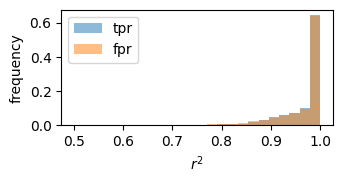

In [260]:
plt.figure(figsize=(3.5, 1.5))
plt.hist(data['r2_tpr'], alpha=0.5, label='tpr', cumulative=False, bins=np.linspace(0.5, 1, 25), weights=np.repeat(1/len(data), len(data)))
plt.hist(data['r2_fpr'], alpha=0.5, label='fpr', cumulative=False, bins=np.linspace(0.5, 1, 25), weights=np.repeat(1/len(data), len(data)))
plt.xlabel(f'$r^2$')
plt.ylabel('frequency')
plt.legend()

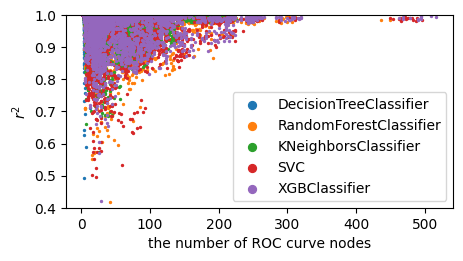

In [261]:
plt.figure(figsize=(5, 2.5))
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd']

for idx, classifier in enumerate(data['classifier'].drop_duplicates()):
    tmp = data[data['classifier'] == classifier]
    plt.scatter(tmp['n_nodes'], tmp['r2_fpr'], s=2, label=classifier, color=colors[idx])
plt.ylim(0.4, 1)
plt.xlabel('the number of ROC curve nodes')
plt.ylabel(f'$r^2$')
plt.legend(markerscale=4)

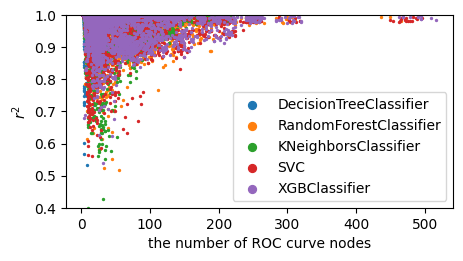

In [262]:
plt.figure(figsize=(5, 2.5))
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd']

for idx, classifier in enumerate(data['classifier'].drop_duplicates()):
    tmp = data[data['classifier'] == classifier]
    plt.scatter(tmp['n_nodes'], tmp['r2_tpr'], s=2, label=classifier, color=colors[idx])
plt.ylim(0.4, 1)
plt.xlabel('the number of ROC curve nodes')
plt.ylabel(f'$r^2$')
plt.legend(markerscale=4)

In [263]:
bins = np.logspace(np.log10(data['n_nodes'].min()), np.log10(data['n_nodes'].max()), 10)
bin_mids = ((bins[1:] + bins[:-1])/2).astype(int)

In [264]:
data['n_nodes_bin'] = data['n_nodes'].apply(
    lambda n_nodes: bin_mids[np.argmin(np.abs(n_nodes - bin_mids))]
)

In [265]:
tmp = data.groupby(['classifier', 'n_nodes_bin']).agg({'r2_fpr': 'mean', 'r2_tpr': 'mean'}).reset_index(drop=False)

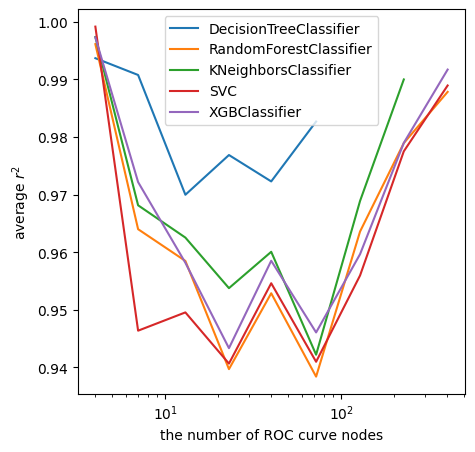

In [266]:
plt.figure(figsize=(5, 5))
for classifier in data['classifier'].drop_duplicates():
    tmp2 = tmp[tmp['classifier'] == classifier]
    plt.plot(tmp2['n_nodes_bin'], tmp2['r2_fpr'], label=classifier)
    plt.xscale('log')
plt.xlabel('the number of ROC curve nodes')
plt.ylabel(f'average $r^2$')
plt.legend()